In [1]:
import os
import json
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)

from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR, SegResNet, UNet
from monai import data
from monai.data import decollate_batch
from functools import partial

import torch


/home/ikboljon.sobirov/miniconda3/envs/lumen/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def datafold_read(datalist, basedir, fold=0, key="training"):
    with open(datalist) as f:
        json_data = json.load(f)

    json_data = json_data[key]

    for d in json_data:
        for k in d:
            if isinstance(d[k], list):
                d[k] = [os.path.join(basedir, iv) for iv in d[k]]
            elif isinstance(d[k], str):
                d[k] = os.path.join(basedir, d[k]) if len(d[k]) > 0 else d[k]

    tr = []
    val = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        else:
            tr.append(d)

    return tr, val

In [3]:
data_dir = '/home/ikboljon.sobirov/data/fs1_research/Ikboljon.Sobirov/imagecas/imagecas/resampled_space/'
json_file = '/home/ikboljon.sobirov/data/nas/ikboljon.sobirov/image_cas/chuqur_organish_asoslari/module_8/train_data.json'
fold = 1
roi = (96, 96, 96)
batch_size = 1
num_crop_samples=4

In [4]:
train_files, validation_files = datafold_read(datalist=json_file, basedir=data_dir, fold=fold)
print(f"Train files: {len(train_files)}, Validation files: {len(validation_files)}")

Train files: 160, Validation files: 40


In [5]:
# z_norm = (img - mean)/std
# min_max = (img - min)/(max - min)

In [6]:
train_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "mask"], ensure_channel_first=True),
        transforms.SpatialPadd(keys=["image", "mask"], spatial_size=roi),
        transforms.RandCropByPosNegLabeld(keys=["image", "mask"], 
                                        label_key="mask",
                                        spatial_size=roi,
                                        num_samples=num_crop_samples,
                                        image_key="image",),
        # transforms.CropForegroundd(
        #     keys=["image", "label"],
        #     source_key="image",
        #     k_divisible=[roi[0], roi[1], roi[2]],
        # ),
        # transforms.RandSpatialCropd(
        #     keys=["image", "label"],
        #     roi_size=[roi[0], roi[1], roi[2]],
        #     random_size=False,
        # ),
        # transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        # transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        # transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        # transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        # transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        # transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)
val_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "mask"], ensure_channel_first=True),
        transforms.SpatialPadd(keys=["image", "mask"], spatial_size=roi),
    ]
)

train_ds = data.Dataset(data=train_files, transform=train_transform)

train_loader = data.DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
)

val_ds = data.Dataset(data=validation_files, transform=val_transform)
val_loader = data.DataLoader(
    val_ds,
    batch_size=1,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)



In [7]:
a = next(iter(train_loader))

In [8]:
a['mask'].shape

torch.Size([4, 1, 96, 96, 96])

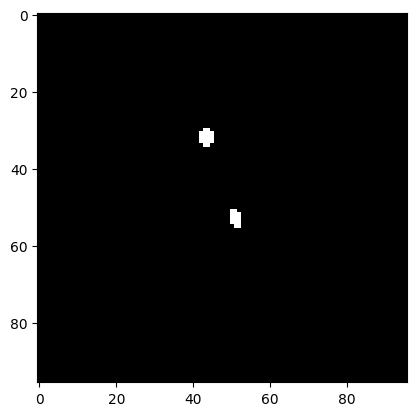

In [9]:
plt.imshow(a['mask'].cpu().detach()[0, 0, :, :, 50], cmap='gray')

In [10]:
# simple segresnet
model = SegResNet(
    in_channels=1,
    out_channels=1,
    init_filters=16,
)

# monster segresnet
# model = SegResNet(
#                 in_channels=1, 
#                 out_channels=1, 
#                 init_filters=32,
#                 norm='BATCH', 
#                 blocks_down=(1,2,2,4,4,4), 
#                 blocks_up=(1,1,1,1,1), 
#                 upsample_mode='deconv',)

# swinunetr
# model = SwinUNETR(
#                 img_size=roi,
#                 in_channels=4,
#                 out_channels=3,
#                 feature_size=48,
#                 drop_rate=0.0,
#                 attn_drop_rate=0.0,
#                 dropout_path_rate=0.0,
#                 use_checkpoint=True,)

In [11]:
torch.backends.cudnn.benchmark = True
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)

loss_function = DiceLoss(to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

dice_metric = DiceMetric(include_background=False, reduction=MetricReduction.MEAN_BATCH, get_not_nans=True)

max_epochs = 10
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
sw_batch_size = 4
infer_overlap = 0.5


model_inferer = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=sw_batch_size,
    predictor=model,
    overlap=infer_overlap,
)

# post_sigmoid = Activations(sigmoid=True)
# post_pred = AsDiscrete(argmax=False, threshold=0.5)


In [12]:
def dice(input, target):
    axes = tuple(range(1, input.dim()))
    bin_input = (input > 0.5).float()

    intersect = (bin_input * target).sum(dim=axes)
    union = bin_input.sum(dim=axes) + target.sum(dim=axes)
    score = 2 * intersect / (union + 1e-5)

    return score.mean()

In [13]:
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    start_time = time.time()
    for idx, batch_data in enumerate(train_loader):
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["mask"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    # print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    print(
            "Epoch {}/{} {}/{}".format(epoch, max_epochs, idx, len(train_loader)),
            "loss: {:.4f}".format(epoch_loss),
            "time {:.2f}s".format(time.time() - start_time),
        )
    start_time = time.time()

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            epoch_dices = []
            for idx, val_data in enumerate(val_loader):
                val_inputs, val_labels = val_data["image"].to(device), val_data["mask"].to(device)
                val_outputs = model_inferer(val_inputs)
                dice_val = dice(val_outputs, val_labels)
                epoch_dices.append(dice_val)
                
                print(f"{idx}/{len(val_ds)} dice: {dice_val:.4f}")
                
            dice_epoch = torch.stack(epoch_dices).mean()

            metric_values.append(dice_epoch)
            if dice_epoch > best_metric:
                best_metric = dice_epoch
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model.pth")
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {dice_epoch:.4f} "
                f"best mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}"
            )

----------
epoch 1/10
1/160, train_loss: 0.9935
2/160, train_loss: 0.9895
3/160, train_loss: 0.9920
4/160, train_loss: 0.9935
5/160, train_loss: 0.9927
6/160, train_loss: 0.9926
7/160, train_loss: 0.9875
8/160, train_loss: 0.9869
9/160, train_loss: 0.9921
10/160, train_loss: 0.9914
11/160, train_loss: 0.9935
12/160, train_loss: 0.9934
13/160, train_loss: 0.9942
14/160, train_loss: 0.9882
15/160, train_loss: 0.9893
16/160, train_loss: 0.9905
17/160, train_loss: 0.9878
18/160, train_loss: 0.9869
19/160, train_loss: 0.9928
20/160, train_loss: 0.9902
21/160, train_loss: 0.9893
22/160, train_loss: 0.9915
23/160, train_loss: 0.9926
24/160, train_loss: 0.9868
25/160, train_loss: 0.9884
26/160, train_loss: 0.9902
27/160, train_loss: 0.9883
28/160, train_loss: 0.9872
29/160, train_loss: 0.9899
30/160, train_loss: 0.9924
31/160, train_loss: 0.9841
32/160, train_loss: 0.9887
33/160, train_loss: 0.9842
34/160, train_loss: 0.9921
35/160, train_loss: 0.9903
36/160, train_loss: 0.9866
37/160, train_l

In [14]:
numpy_metrics = np.array([tensor.cpu().numpy() for tensor in metric_values])

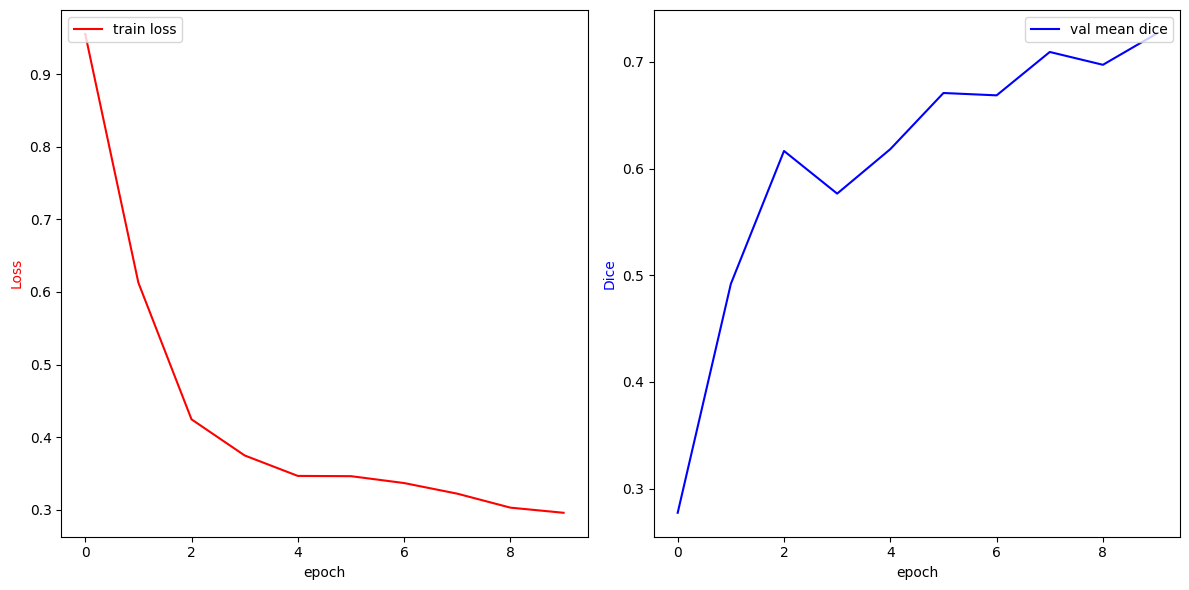

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for train loss
ax1.plot(range(max_epochs), epoch_loss_values, "r", label="train loss")
ax1.set_xlabel("epoch", color="k")
ax1.set_ylabel("Loss", color="r")
ax1.legend(loc="upper left")

# Plot for validation mean dice
ax2.plot(range(max_epochs), numpy_metrics, "b", label="val mean dice")
ax2.set_xlabel("epoch", color="k")
ax2.set_ylabel("Dice", color="b")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()